In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch

# --- 1. Load Data and Embeddings ---

df = pd.read_parquet('processed_customer_support_data.parquet')
df['combined_text'] = df['Ticket Subject'] + " | " + df['Cleaned_Description']

In [10]:
# Try to load the embeddings file. If it doesn't exist, regenerate it.
try:
    all_embeddings = np.load('all_embeddings.npy')
    print("Pre-computed embeddings loaded successfully.")
except FileNotFoundError:
    print("Embeddings file not found. Regenerating... (This may take a few minutes)")
    model_name = "best-gatekeeper-model"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    def get_embeddings(texts, batch_size=32):
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embs.append(embs)
        return np.vstack(all_embs)
        
    all_embeddings = get_embeddings(df['combined_text'].tolist())
    np.save('all_embeddings.npy', all_embeddings) # Save for future use
    print("Embeddings generated and saved as 'all_embeddings.npy'.")

print(f"Shape of the embedding matrix: {all_embeddings.shape}")

Pre-computed embeddings loaded successfully.
Shape of the embedding matrix: (8469, 768)



Calculating inertia for different values of K...
Inertia for K=2: 25314.5859375
Inertia for K=3: 22902.30078125
Inertia for K=4: 20850.99609375
Inertia for K=5: 19730.4609375
Inertia for K=6: 19089.23046875
Inertia for K=7: 18786.2421875
Inertia for K=8: 18443.001953125
Inertia for K=9: 17643.6875
Inertia for K=10: 17357.0234375
Inertia for K=11: 17112.609375
Inertia for K=12: 16814.421875
Inertia for K=13: 16608.529296875
Inertia for K=14: 16359.984375
Inertia for K=15: 16167.685546875
Inertia for K=16: 16029.85546875
Inertia for K=17: 15877.0849609375
Inertia for K=18: 15683.1259765625
Inertia for K=19: 15566.34765625
Inertia for K=20: 15452.9326171875
Inertia for K=21: 15291.91015625
Inertia for K=22: 15302.73046875
Inertia for K=23: 15088.2890625
Inertia for K=24: 14929.1015625
Inertia for K=25: 14874.048828125
Inertia for K=26: 14802.689453125
Inertia for K=27: 14684.4091796875
Inertia for K=28: 14557.24609375
Inertia for K=29: 14407.087890625
Inertia for K=30: 14336.87890625
Ine

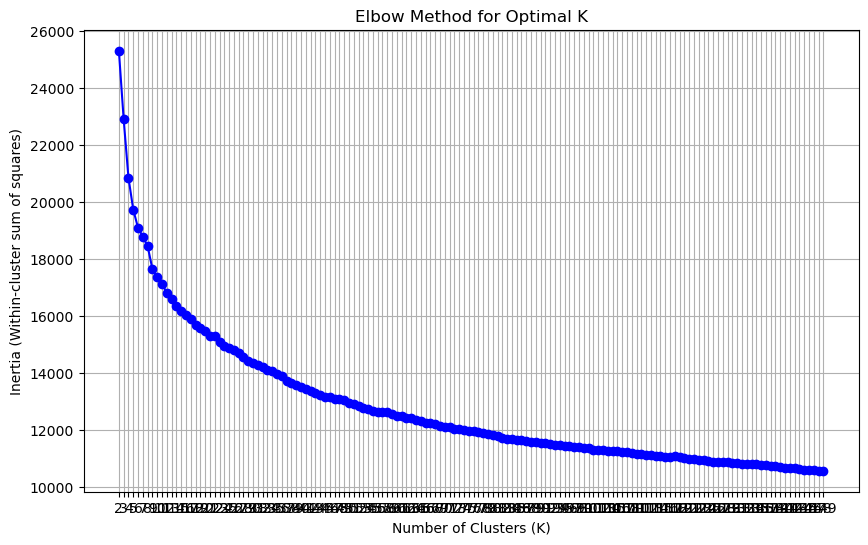

In [11]:
# --- 2. Find the Optimal K using the Elbow Method ---

print("\nCalculating inertia for different values of K...")
inertia = []
K_range = range(2, 150) # We will test from 2 to 15 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(all_embeddings)
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K={k}: {kmeans.inertia_}")

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

# How to Use This Analysis: From Clusters to Business Strategy

The K-Means clustering has provided a powerful, unsupervised view into the natural structure of customer support tickets. Unlike our supervised models which categorize based on predefined labels, this analysis reveals the inherent groupings within the data itself.

Here is a practical guide on how to leverage these findings.

### 1. Validate the Supervised Model Strategy

The clustering results provide a strong, independent validation for the hierarchical classification system we developed.

*   **Finding:** **Cluster 1** perfectly isolated all 509 "Account Access" tickets with 100% purity.
*   **Action:** This confirms that "Account Access" tickets are semantically unique and that our strategy of building a specialized "Gatekeeper" model to identify and route them first was the correct approach. It gives us high confidence in that part of the automated system.

### 2. Inform Support Team Specialization

The clusters reveal natural "areas of responsibility" that are more nuanced than our original four categories. HelpNow can use this to structure its support teams for greater efficiency.

*   **Finding:** **Cluster 3 ("Critical System & Network Failures")** contains the most severe technical problems like `Software bug`, `Hardware issue`, and `Network problem`.
*   **Action:** Create a **Tier 2 / Escalation Team** that specializes in these complex, high-priority issues. New tickets whose embeddings fall into this cluster can be flagged for immediate attention from these experts.

*   **Finding:** **Clusters 0 & 5 ("Product Onboarding & Usability")** are dominated by subjects like `Installation support`, `Product setup`, `Product compatibility`, and `Product recommendation`.
*   **Action:** Form a **Customer Success / Onboarding Team**. This team can be trained specifically on the initial user experience and equipped with detailed documentation, setup guides, and video tutorials. This team's goal would be to help new users find value in the product quickly.

### 3. Guide Product & Documentation Improvements

The size and content of the clusters are a direct reflection of customer pain points. This is invaluable feedback for the product and documentation teams.

*   **Finding:** The "Product Onboarding & Usability" clusters (0 and 5) are very large, containing over 4,100 tickets combined. `Installation support` and `Product setup` appear as top subjects in both.
*   **Action:** This is a clear, data-driven signal that the initial user experience is a major source of support requests. The product team should prioritize improving the setup wizard, in-app guidance, and overall ease of use. The documentation team should create a comprehensive "Getting Started" guide to address these common issues proactively.

*   **Finding:** **Cluster 3 ("Critical Failures")** is the largest single cluster. The top subject is `Software bug`.
*   **Action:** Provide this data to the engineering team. By analyzing the tickets within this cluster, they can prioritize fixing the bugs that are causing the most customer issues, thereby reducing the support workload over time.

### 4. Enhance Proactive Support

By understanding these ticket clusters, the support team can move from being reactive to proactive.

*   **Finding:** The top subjects in each cluster represent the most common problems within that topic.
*   **Action:** For the top 3 subjects in each of the major clusters, create pre-written responses (macros) and detailed knowledge base articles. When a new ticket is identified as belonging to a specific cluster, the support agent can be automatically prompted with these relevant resources, speeding up response times and ensuring consistency.

By integrating these unsupervised insights, HelpNow can not only streamline its current support operations but also make smarter, data-driven decisions about team structure, product development, and customer success strategy.

Calculating Silhouette Scores for K in [5, 50]...
Silhouette Score for K=5: 0.1302
Silhouette Score for K=6: 0.1219
Silhouette Score for K=7: 0.1128
Silhouette Score for K=8: 0.1019
Silhouette Score for K=9: 0.0765
Silhouette Score for K=10: 0.0727
Silhouette Score for K=11: 0.0729
Silhouette Score for K=12: 0.0729
Silhouette Score for K=13: 0.0687
Silhouette Score for K=14: 0.0763
Silhouette Score for K=15: 0.0707
Silhouette Score for K=16: 0.0718
Silhouette Score for K=17: 0.0716
Silhouette Score for K=18: 0.0767
Silhouette Score for K=19: 0.0794
Silhouette Score for K=20: 0.0802
Silhouette Score for K=21: 0.0787
Silhouette Score for K=22: 0.0730
Silhouette Score for K=23: 0.0789
Silhouette Score for K=24: 0.0829
Silhouette Score for K=25: 0.0779
Silhouette Score for K=26: 0.0752
Silhouette Score for K=27: 0.0719
Silhouette Score for K=28: 0.0771
Silhouette Score for K=29: 0.0805
Silhouette Score for K=30: 0.0791
Silhouette Score for K=31: 0.0794
Silhouette Score for K=32: 0.0797
Sil

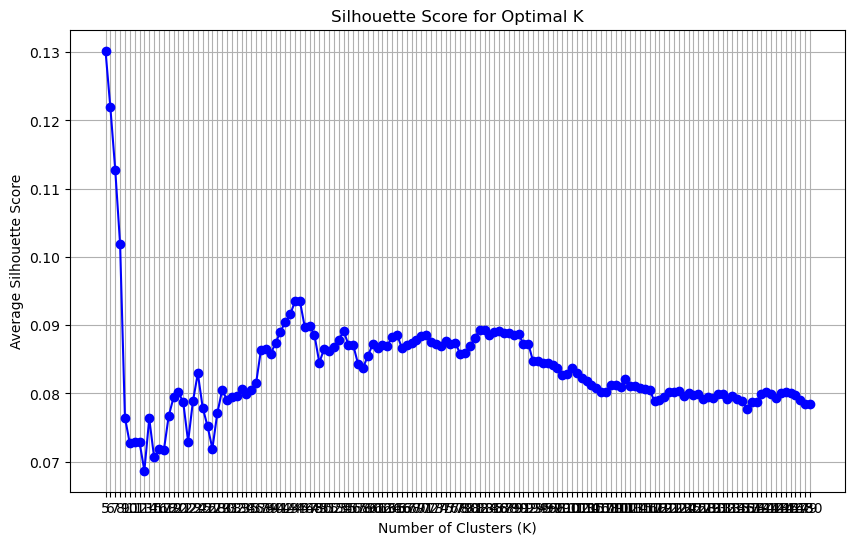


--- Final Cluster Analysis with K=5 ---

--- Cluster 0 (Size: 3279) ---

Category Distribution:
Category
Billing            60.45%
Technical Issue    19.98%
General Query      19.58%
Name: proportion, dtype: object

Top 5 Ticket Subjects:
Ticket Subject
Product recommendation    267
Installation support      263
Product compatibility     254
Battery life              251
Refund request            250
Name: count, dtype: int64

--- Cluster 1 (Size: 509) ---

Category Distribution:
Category
Account Access    100.00%
Name: proportion, dtype: object

Top 5 Ticket Subjects:
Ticket Subject
Account access    509
Name: count, dtype: int64

--- Cluster 2 (Size: 516) ---

Category Distribution:
Category
Billing            59.88%
Technical Issue    20.35%
General Query      19.77%
Name: proportion, dtype: object

Top 5 Ticket Subjects:
Ticket Subject
Installation support        44
Peripheral compatibility    42
Delivery problem            41
Product recommendation      40
Payment issue          

In [12]:
from sklearn.metrics import silhouette_score

# --- 3. Find the Optimal K using Silhouette Score ---
# We will test the promising range from our Elbow plot: 5 to 9

K_range_silhouette = range(5, 151) # Test K=5, 6, 7, 8, 9
silhouette_scores = []

print("Calculating Silhouette Scores for K in [5, 50]...")
for k in K_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(all_embeddings)
    
    # Calculate the average silhouette score
    score = silhouette_score(all_embeddings, cluster_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for K={k}: {score:.4f}")

# Find the optimal K with the highest score
optimal_k_silhouette = K_range_silhouette[np.argmax(silhouette_scores)]
print(f"\nOptimal K based on highest Silhouette Score: {optimal_k_silhouette}")

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.xticks(K_range_silhouette)
plt.grid(True)
plt.show()

# --- 4. Re-run Final Analysis with the Best K ---
print(f"\n--- Final Cluster Analysis with K={optimal_k_silhouette} ---")
kmeans_final = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init='auto')
df['cluster_final'] = kmeans_final.fit_predict(all_embeddings)

for i in range(optimal_k_silhouette):
    cluster_df = df[df['cluster_final'] == i]
    print(f"\n--- Cluster {i} (Size: {len(cluster_df)}) ---")
    print("\nCategory Distribution:")
    print(cluster_df['Category'].value_counts(normalize=True).apply("{:.2%}".format))
    print("\nTop 5 Ticket Subjects:")
    print(cluster_df['Ticket Subject'].value_counts().head(5))

In [ ]:
import pandas as pd

# --- 6. Comprehensive Analysis: Generate Examples for All K (2 to 50) ---

# This list will store all the data before we convert it to a DataFrame
all_clusters_data = []
K_range_full = range(2, 150) # As per your elbow plot K range

print("Starting comprehensive analysis for K=2 to K=50...")
print("This will take a few minutes as it runs K-Means multiple times.")

for k in K_range_full:
    print(f"Processing K={k}...")
    # 1. Run K-Means for the current value of K
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(all_embeddings)
    df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K

    # 2. Loop through each cluster for the current K
    for i in range(k):
        cluster_df = df[df[f'cluster_{k}'] == i]
        
        # 3. Find one resolved ticket example
        resolved_example = cluster_df[cluster_df['Resolution'].notna()]
        if not resolved_example.empty:
            resolved_text = resolved_example.iloc[0]['combined_text']
        else:
            resolved_text = "N/A" # No resolved tickets in this cluster

        # 4. Find one unresolved ticket example
        unresolved_example = cluster_df[cluster_df['Resolution'].isna()]
        if not unresolved_example.empty:
            unresolved_text = unresolved_example.iloc[0]['combined_text']
        else:
            unresolved_text = "N/A" # No unresolved tickets in this cluster
            
        # 5. Append the collected data to our list
        all_clusters_data.append({
            "Number of Clusters (K)": k,
            "Cluster ID": i,
            "Cluster Size": len(cluster_df),
            "Resolved Ticket Example": resolved_text,
            "Unresolved Ticket Example": unresolved_text
        })

# 6. Create the final, comprehensive DataFrame
final_comprehensive_df = pd.DataFrame(all_clusters_data)

# 7. Save the DataFrame to a CSV file
output_filename = 'cluster_analysis_examples.csv'
final_comprehensive_df.to_csv(output_filename, index=False)

print(f"\nComprehensive analysis complete.")
print(f"Results have been saved to '{output_filename}'.")

# Display the first 10 rows of the final DataFrame as a preview
print("\nPreview of the final CSV output:")
print(final_comprehensive_df.head(10))

Starting comprehensive analysis for K=2 to K=50...
This will take a few minutes as it runs K-Means multiple times.
Processing K=2...
Processing K=3...
Processing K=4...
Processing K=5...
Processing K=6...
Processing K=7...
Processing K=8...
Processing K=9...
Processing K=10...
Processing K=11...
Processing K=12...
Processing K=13...
Processing K=14...
Processing K=15...
Processing K=16...
Processing K=17...
Processing K=18...
Processing K=19...
Processing K=20...
Processing K=21...
Processing K=22...
Processing K=23...
Processing K=24...
Processing K=25...
Processing K=26...
Processing K=27...
Processing K=28...
Processing K=29...
Processing K=30...
Processing K=31...
Processing K=32...
Processing K=33...
Processing K=34...
Processing K=35...
Processing K=36...
Processing K=37...
Processing K=38...
Processing K=39...
Processing K=40...
Processing K=41...
Processing K=42...
Processing K=43...
Processing K=44...
Processing K=45...
Processing K=46...
Processing K=47...
Processing K=48...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=97...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=98...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=99...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=100...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=101...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=102...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=103...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=104...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=105...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=106...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=107...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=108...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_15823/3287682180.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cluster_{k}'] = cluster_labels # Create a temporary column for this K


Processing K=109...
